<a href="https://colab.research.google.com/github/deguc/Shannon/blob/main/002_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

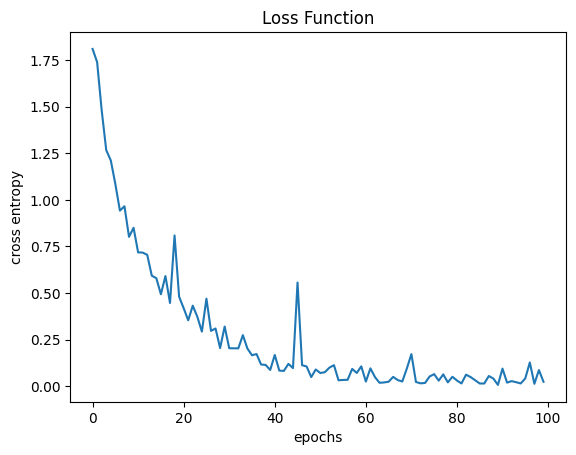

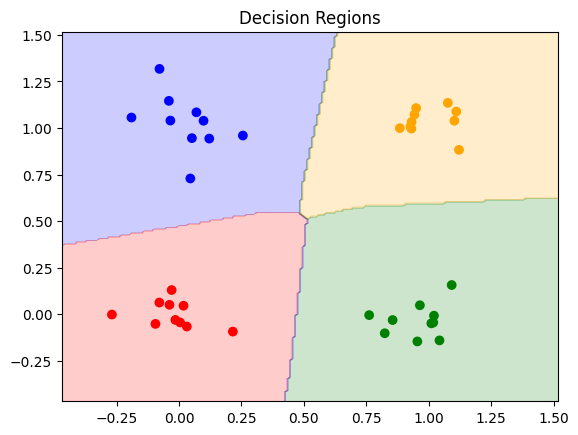

[0 1 2 3]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def onehot(x):

    k = x.max()+1

    return np.identity(k)[x]


def dataset(x,y,size=10,scale=0.1):

    k = x.shape[1]
    X,Y = [],[]

    for x0,y0 in zip(x,y):

        X += [x0+np.random.randn(size,k)*scale]
        Y += [np.full(size,y0)]

    return np.vstack(X),onehot(np.hstack(Y))


class DataLoader:

    def __init__(self,dataset,batch_size):

        self.x,self.y = dataset
        self.batch_size = batch_size
        self.data_size = self.x.shape[0]
        self.cnt = 0

    def shuffle(self):

        idx = np.random.permutation(self.data_size)
        self.x = self.x[idx]
        self.y = self.y[idx]

    def __len__(self):
        return self.data_size // self.batch_size

    def __iter__(self):
        return self

    def __next__(self):

        if self.cnt == 0:
            self.shuffle()

        i = self.cnt
        j = i + self.batch_size

        if j > self.data_size:

            self.cnt = 0
            raise StopIteration

        else:

            self.cnt = j

            return self.x[i:j],self.y[i:j]

    def __getitem__(self,idx):

        if idx <0 or idx >= len(self):
            raise IndexError('out of index')

        i = idx * self.batch_size
        j = i + self.batch_size

        return self.x[i:j],self.y[i:j]


class Module:

    def __init__(self):

        self.ps,self.gs = [],[]
        self.train_flag = False
        self.mask = None
        self.inputs = None
        self.out = None


def zeros_ps(ps):

    gs = []

    for p in ps:
        gs += [np.zeros_like(p)]

    return gs


class Linear(Module):

    def __init__(self,d_in,d_out):
        super().__init__()

        he = np.sqrt(d_in/2)

        self.ps = [
            np.random.randn(d_in,d_out)/he,
            np.zeros(d_out)
        ]
        self.gs = zeros_ps(self.ps)

    def __call__(self, x):

        self.inputs = x.copy()

        return x @ self.ps[0] + self.ps[1]

    def backward(self, dout):

        self.gs[0][...] = self.inputs.T @ dout
        self.gs[1][...] = np.sum(dout,axis=0)

        return dout @ self.ps[0].T


class ReLU(Module):

    def __init__(self):
        super().__init__()

    def __call__(self, x):

        self.mask = x < 0
        out = x.copy()
        out [self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0

        return dout


class Dropout(Module):

    def __init__(self,drop_rate=0.1):
        super().__init__()
        self.drop_rate = drop_rate

    def __call__(self,x):

        if self.train_flag:
            r = self.drop_rate
        else:
            r = 0

        self.mask = np.random.rand(*x.shape) > r

        return x * self.mask /(1-r)

    def backward(self,dout):

        return dout * self.mask /(1-self.drop_rate)


class BatchNorm(Module):

    def __init__(self,dim):
        super().__init__()

        self.ps = [
            np.ones(dim),
            np.zeros(dim)
        ]
        self.gs = zeros_ps(self.ps)

        self.mu = np.zeros(dim)
        self.var = np.ones(dim)

        self.cache = None

        self.eps = 1e-6

    def __call__(self,x):

        if self.train_flag:

            mu = np.mean(x,axis=0)
            var = np.var(x,axis=0)
            centered = x-mu
            std_inv = 1/np.sqrt(var+self.eps)
            norm = centered * std_inv
            self.cache = (centered,std_inv,norm)

            self.mu[...] = 0.9*self.mu + 0.1 * mu
            self.var[...] = 0.9*self.var + 0.1*var

        else:
            norm = (x-self.mu)/np.sqrt(self.var+self.eps)

        return self.ps[0] * norm + self.ps[1]

    def backward(self,dout):

        centered,std_inv,norm = self.cache

        self.gs[0][...] = np.sum(dout*norm,axis=0)
        self.gs[1][...] = np.sum(dout,axis=0)

        dnorm = self.ps[0] * dout
        dvar = -0.5*np.sum(dnorm*centered*std_inv**3,axis=0)
        dmu = -np.sum(dnorm*std_inv,axis=0)-2.0*np.mean(dvar*centered)

        n = dout.shape[0]

        return dnorm*std_inv+2.0*dvar*centered/n+dmu/n




def softmax(y,t):

    eps = 1e-6
    n = y.shape[0]

    c = np.max(y,axis=-1,keepdims=True)
    e = np.exp(y-c)
    Z = np.sum(e,axis=-1,keepdims=True)
    out = e/Z

    dout = (out-t)/n

    loss = -np.sum(t*np.log(out+eps))/n

    return dout,loss


class Layers:

    def __init__(self,layers):

        self.layers = layers
        self.ps = [[],[]]

        for l in self.layers:
            self.ps[0] += l.ps
            self.ps[1] += l.gs

    def __call__(self,x):

        for l in self.layers:
            x = l(x)

        return x

    def backward(self,dout):

        for l in reversed(self.layers):
            dout = l.backward(dout)

    def train(self):

        for l in self.layers:
            l.train_flag = True

    def eval(self):

        for l in self.layers:
            l.train_flag = False

    def pred(self,x):
        return np.argmax(self(x),axis=-1)


class AdamW:

    def __init__(self,ps,lr=0.1,beta1=0.2,beta2=0.9,weight_decay=0.1):

        self.ps =ps
        self.cache = (lr,beta1,beta2,weight_decay)
        self.hs = [
            zeros_ps(self.ps[0]),
            zeros_ps(self.ps[0])
        ]
        self.cnt = 0

    def __call__(self):

        eps = 1e-6
        ps,gs = self.ps
        ms,vs = self.hs
        lr,b1,b2,w = self.cache
        self.cnt += 1
        n = self.cnt

        for p,g,m,v in zip(ps,gs,ms,vs):

            m[...] = b1*m + (1-b1)*g
            v[...] = b2*v + (1-b2)*g*g

            m0 = m / (1-b1**n)
            v0 = v / (1-b2**n)

            p -= w*lr*p

            p -= lr*m0 / (np.sqrt(v0)+eps)


def trainer(model,optimizer,data,epochs=200):

    loss = []

    for _ in range(epochs):

        ls = 0

        model.train()

        for x,t,in  data:

            y = model(x)
            dout,l = softmax(y,t)
            ls += l
            model.backward(dout)
            optimizer()

        loss += [ls/len(data)]
        model.eval()

    return loss


def disp_loss(loss):

    plt.title('Loss Function')
    plt.xlabel('epochs')
    plt.ylabel('cross entropy')
    plt.plot(loss)

    plt.show()


def decision_regions(model,data,resolutin=200):

    x = data.x
    y = np.argmax(data.y,axis=-1)

    color = ['red','blue','green','orange']

    x_min = x.min()-0.2
    x_max = x.max()+0.2

    x1 = np.linspace(x_min,x_max,resolutin)
    x2 = np.linspace(x_min,x_max,resolutin)

    xx1,xx2 = np.meshgrid(x1,x2)
    xx = np.array([xx1.flatten(),xx2.flatten()]).T
    z = model.pred(xx).reshape(xx1.shape)

    cmap = ListedColormap(color[:y.max()+1])

    plt.contourf(xx1,xx2,z,cmap=cmap,alpha=0.2)



    c = [color[i] for i in y]
    plt.scatter(x[:,0],x[:,1],c=c)

    plt.title('Decision Regions')
    plt.show()


x = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([0,1,2,3])

dataset = dataset(x,y,size=10,scale=0.1)
data = DataLoader(dataset,batch_size=10)

d_in = x.shape[1]
d_h = 4*d_in
d_out = y.max()+1

layers = [
    Linear(d_in,d_h),
    BatchNorm(d_h),
    ReLU(),
    Dropout(drop_rate=0.02),
    Linear(d_h,d_out)
]
model = Layers(layers)
optimizer = AdamW(model.ps,lr=0.01)
loss = trainer(model,optimizer,data,epochs=100)

disp_loss(loss)
decision_regions(model,data)

pred = model.pred(x)
print(pred)

